# CS498PS - Lab 3: Artificial Reverberation and Room Simulation


In this lab we will get some experience in simulating rooms digitally. We will design some simple reverbs using small filters and then work towards a more principled room simulator. You can use whichever sound you like for the following examples, usually a sound with sharp onsets is good for such experiments. One good example is the drum loop [ https://drive.google.com/uc?export=download&id=16mqI3xFN00AK5bP5k1VYJiEfH7ghHHSf ]

## Part 1. Designing simple reverb using filters

The simplest forms of reverbs can be designed using simple delays, comb and allpass filters. We will design one of each to get started.

a) A room with a single wall. For this reverb we will assume that we have a room that only has one reflective wall as shown below. Design a filter that simulates what the microphone will record. figure out the right filter in the case where $d_i = [0.1, 1]$ meters, and in the case where $d_i = [1, 10]$ meters. Let me know what the differences between these sounds are. To keep things simple, round the delays to an integer number and make up an approximate gain loss due to propagation and the wall bounce.

<img src="https://drive.google.com/uc?export=download&id=1uaSmnwcXAtN29RtWQymUfmw2i-AuTl_g" title="Room for part 1.a" width=200 >

In [3]:
# YOUR CODE HERE
import numpy as np
import scipy.io.wavfile
import scipy.signal
import scipy
import math
import matplotlib.pyplot as plt

# Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

loop_sr, loop_audio = scipy.io.wavfile.read('data/Lab3/loop.wav')

sound(loop_audio, rate=loop_sr, label='drum loop')
impulse_response_1 = np.zeros(int(2.0/343*loop_sr)+1)
impulse_response_1[int(2.0/343*loop_sr)] = 0.75
impulse_response_1[int(0.1/343*loop_sr)] = 1.0
single_wall_audio_1 = scipy.signal.lfilter(impulse_response_1, [1], loop_audio)
sound(single_wall_audio_1, rate=loop_sr, label='single wall [0.1,1]')

impulse_response_2 = np.zeros(int(20.0/343*loop_sr)+1)
impulse_response_2[int(20.0/343*loop_sr)] = 0.75
impulse_response_2[int(1.0/343*loop_sr)] = 1.0
single_wall_audio_2 = scipy.signal.lfilter(impulse_response_2, [1], loop_audio)
sound(single_wall_audio_2, rate=loop_sr, label='single wall [1,10]')

#the longer distance reverberation has a much more audibly noticeable echo than the shorter distance echo

b) Now we will use a room geometry as shown below. Design the proper filter again, for $d_i = [0.1, 1]$ meters and then for $d_i = [1, 10]$ meters. Comment on the audible differences between these two settings.

<img src="https://drive.google.com/uc?export=download&id=1uYqG6VqhPegoxuJwvJCqm0zY7Ced-3Ih" title="Room for part 1.b" width=200 >

In [17]:
# YOUR CODE HERE
impulse_response_3 = np.zeros(int(2.0/343*loop_sr)*15+1)
for i in range(15):
    impulse_response_3[(i+1)*int(2.0/343*loop_sr)] = (0.75)**(i+1)
impulse_response_3[int(0.1/343*loop_sr)] = 1.0
double_wall_audio_1 = scipy.signal.lfilter(impulse_response_3, [1], loop_audio)
sound(double_wall_audio_1, rate=loop_sr, label='double wall [0.1,1]')

impulse_response_4 = np.zeros(int(20.0/343*loop_sr)*15+1)
for i in range(15):
    impulse_response_4[(i+1)*int(20.0/343*loop_sr)] = (0.75)**(i+1)
impulse_response_4[int(1.0/343*loop_sr)] = 1.0
double_wall_audio_2 = scipy.signal.lfilter(impulse_response_4, [1], loop_audio)
sound(double_wall_audio_2, rate=loop_sr, label='double wall [1,10]')
#the longer distance reverberation again has a much more audibly noticeable echo than the shorter distance one

c) Since for small values of $d$ the output above gets its spectrum altered, we will use an allpass filter to make a more natural sounding echo pattern. Use the formulation shown in the lecture slides and compare that filter’s frequency response with the response from the filter in the section b) above.

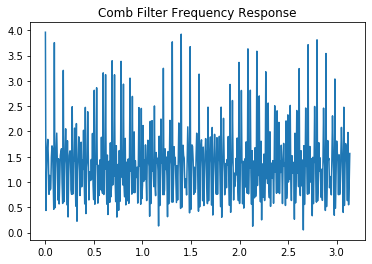

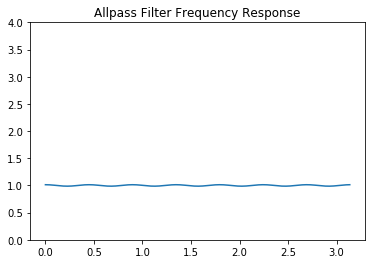

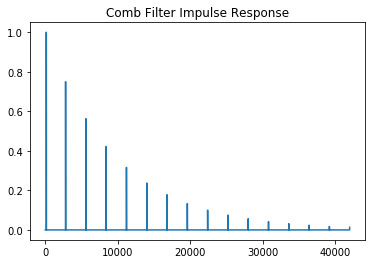

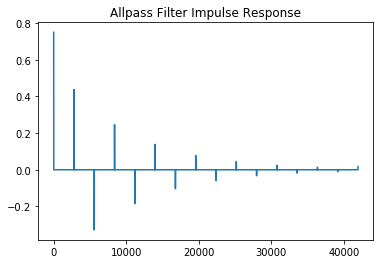

In [18]:
# YOUR CODE HERE
allpass_impulse_response = np.zeros(int(20.0/343*loop_sr)*15+1)
j = 1
for i in range(15):
    allpass_impulse_response[i*int(20.0/343*loop_sr)] += ((0.75)**(i+1))*j
    allpass_impulse_response[(i+1)*int(20.0/343*loop_sr)] += ((0.75)**i)*j
    j*=-1
all_pass_audio = scipy.signal.lfilter(allpass_impulse_response, [1], loop_audio)
sound(all_pass_audio, rate=loop_sr, label='allpass audio')

plt.figure(1)
plt.title("Comb Filter Frequency Response")
comb_w, comb_h = scipy.signal.freqz(impulse_response_4)
plt.plot(comb_w, np.abs(comb_h))

plt.figure(2)
plt.title("Allpass Filter Frequency Response")
allpass_w, allpass_h = scipy.signal.freqz(allpass_impulse_response)
plt.ylim(bottom=0,top=4.0)
plt.plot(allpass_w, np.abs(allpass_h))

plt.figure(3)
plt.title("Comb Filter Impulse Response")
plt.plot(impulse_response_4)

plt.figure(4)
plt.title("Allpass Filter Impulse Response")
plt.plot(allpass_impulse_response)

## Part 2. Schroeder reverberators

Now we will combine multiple filters to make a more serious sounding reverb. Implement the structure shown below.

<img src="https://drive.google.com/uc?export=download&id=1ubIkl8Qn3osku39tym2ayxVk6KdC95ui" title="Reverb for part 2" width=600 >

Try to find the necessary parameters for the above structure that makes it sound as good as possible (not too busy, not too subtle). Hint: There is no right answer! Try a few things, see what sounds best and explain why you used the parameters you decided to use. As you come across some bad sounding cases, describe what the problem was.

In [16]:
# YOUR CODE HERE
comb_impulse_1 = np.zeros(int(2.0/343*loop_sr)*15+1)
for i in range(15):
    comb_impulse_1[i*int(2.0/343*loop_sr)] = 0.75**i

comb_impulse_2 = np.zeros(int(8.0/343*loop_sr)*15+1)
for i in range(15):
    comb_impulse_2[i*int(8.0/343*loop_sr)] = 0.75**i
    
comb_impulse_3 = np.zeros(int(14.0/343*loop_sr)*15+1)
for i in range(15):
    comb_impulse_3[i*int(14.0/343*loop_sr)] = 0.75**i
    
comb_impulse_4 = np.zeros(int(20.0/343*loop_sr)*15+1)
for i in range(15):
    comb_impulse_4[i*int(20.0/343*loop_sr)] = 0.75**i
    
comb_audio_1 = scipy.signal.lfilter(comb_impulse_1, [1], loop_audio)
comb_audio_2 = scipy.signal.lfilter(comb_impulse_2, [1], loop_audio)
comb_audio_3 = scipy.signal.lfilter(comb_impulse_3, [1], loop_audio)
comb_audio_4 = scipy.signal.lfilter(comb_impulse_4, [1], loop_audio)
comb_audio = np.zeros(np.shape(comb_audio_1))
comb_audio += comb_audio_1 + comb_audio_2 + comb_audio_3 + comb_audio_4

allpass_impulse_1 = np.zeros(int(10.0/343*loop_sr)*15+1)
j = 1
for i in range(15):
    allpass_impulse_1[i*int(10.0/343*loop_sr)] += ((0.75)**(i+1))*j
    allpass_impulse_1[(i+1)*int(10.0/343*loop_sr)] += ((0.75)**i)*j
    j*=-1

allpass_impulse_2 = np.zeros(int(40.0/343*loop_sr)*15+1)
j = 1
for i in range(15):
    allpass_impulse_2[i*int(40.0/343*loop_sr)] += ((0.75)**(i+1))*j
    allpass_impulse_2[(i+1)*int(40.0/343*loop_sr)] += ((0.75)**i)*j
    j*=-1

allpass_audio_1 = scipy.signal.lfilter(allpass_impulse_1, [1], comb_audio)
allpass_audio_2 = scipy.signal.lfilter(allpass_impulse_2, [1], allpass_audio_1)

sound(allpass_audio_2, rate=loop_sr, label='schroeder reverb')

## Part 3. Applying a real room response

To apply a more realistic filter we need to use a real room response. Download the St. Andrew’s church room impulse response (Stereo) from:

[ https://openairlib.net/?page_id=683 ]
    
Make sure that the sound you will convolve with it will be at the same sampling rate. This impulse response captures that church’s RIR using two channels. To synthesize a sound in that room you need to convolve it with the impulse response. If your test sound is a single-channel recording, you can simply convolve it with each of the two impulse responses and then use the resulting outputs as the left and right channel. You will notice that using the ```scipy.signal.lfilter``` command for this operation can take very long to compute. For faster convolutions we need to perform this filtering in the frequency domain (using the fast convolution algorithm that we mentioned in the filtering lecture). The function ```numpy.convolve``` automatically does that (if you use an up to date version), otherwise you can directly use ```scipy.signal.fftconvolve```.  Verify that the resulting output sounds like it has been placed inside a church.


In [22]:
# YOUR CODE HERE
sta_sr, sta_audio = scipy.io.wavfile.read('data/Lab3/st_andrews.wav')
left_channel = scipy.signal.fftconvolve(loop_audio, sta_audio[:,0])
right_channel = scipy.signal.fftconvolve(loop_audio, sta_audio[:,1])
church_audio = np.zeros((2,np.shape(left_channel)[0]))
church_audio[0] = left_channel
church_audio[1] = right_channel
sound(church_audio, rate=loop_sr, label='church audio')

## Part 4 (extra credit). Measuring a room response.

Measuring a room response is crucial when trying to emulate a real room. In this exercise we will make a simple room response measurement. We will use the technique shown in the lecture slides.

a) Generate a chirp to use as our room excitation signal.

b) Go to a (preferably quiet) room that you want to measure, play the chirp from a speaker and record the outcome (the easiest way to do that is to save this sequence as a wave file and play it while you record a new sound file). You can instead use the real-time I/O code from Lab 0. In doing so you will obtain the sequence $y[t]$ from slide 36.

c) Now you will need to perform the actual deconvolution. Take $x[t]$ and $y[t]$, compute their DFTs to get $X[ω]$ and $Y[ω]$, and estimate $H[ω]$ (remember to zero pad the inputs since the output of the convolution will be about twice as long as the inputs). Take the inverse DFT of $H$ to get the time domain representation of the room impulse response. Does it look like one?

d) Convolve the resulting response with the test sound above (make sure you use the same sample rates). Does it sound reverberated? This won’t be perfect. What sounds “wrong” with it? Can you speculate why?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()